## Vehicle Detection Project
The purpose of this project is to create a pipeline which can detect vehicles in a video stream and draw bounding boxes around those vehicle

In [1]:
import glob
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.externals import joblib
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label

% matplotlib inline

### Utility functions from Vehicle Detection and Tracking Lesson
Many useful functions for computing HOG features, spatial features, histogram features, image segmentation, and drawing boxes were provided in the course material for the Vehicle Detection and Tracking lesson. The provided functions which I used for this project are copied below.

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features) 
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Prepare dataset for training an testing of SVM classifier.
It takes images and classifies them as 'car' or 'not car'. The classifier used here is an implementation of a SVM trained on example images with cars and example images without cars. These images are taken from the GTI and KITTI datasets. The below code creates two lists.

Total vehicles: 8792, Total non-vehicles: 8968
of size:  (64, 64, 3)  and data type: float32


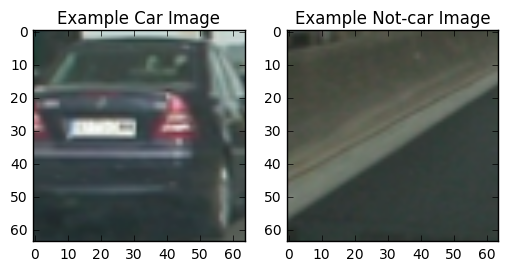

In [3]:
# Divide up into cars and notcars

images_vehicle = glob.glob('data/vehicles/*/*.png')
images_nonvehicle = glob.glob('data/non-vehicles/*/*.png')
print('Total vehicles: {}, Total non-vehicles: {}'.format(len(images_vehicle), len(images_nonvehicle)))

cars = []
notcars = []
for image in images_vehicle:
    #if 'image' in image or 'extra' in image:
    cars.append(image)
for image in images_nonvehicle:
    notcars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

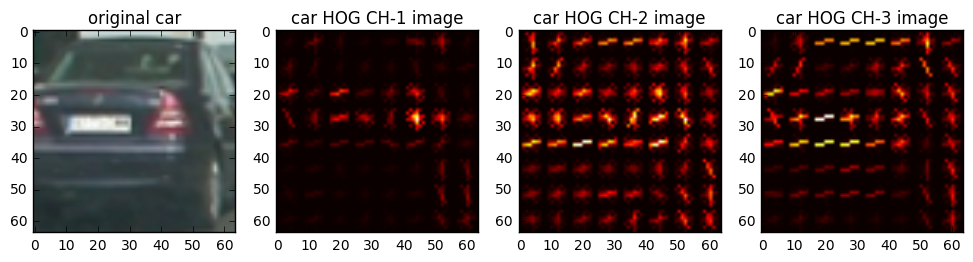

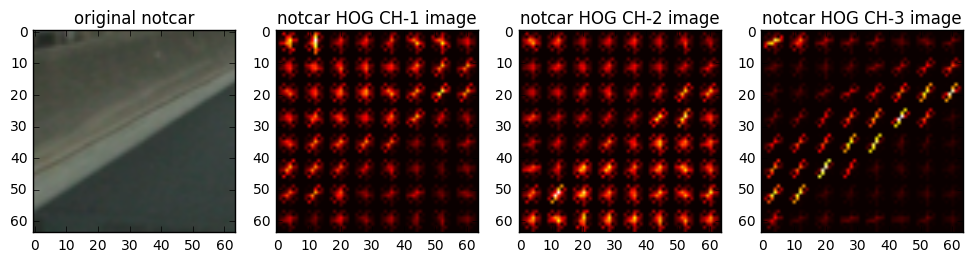

In [4]:
#Define feature parameters.  
#HSV tends better to RGB
#HOG channel with ALL boost up the predication accuracy.

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



def draw_hog_examples(type_of_image,image, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                      hog_channel=hog_channel):

    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #hls  = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    hog_features = []
    
    _, axarr = plt.subplots(1, 4, figsize=(12,3))
    axarr[0].set_title('original '+type_of_image)
    axarr[0].imshow(image)
    
    for channel in range(feature_image.shape[2]):
        
        features, hog_image = get_hog_features(img=feature_image[:, :, channel],
                                               orient=orient,
                                               cell_per_block=cell_per_block,
                                               pix_per_cell=pix_per_cell,vis=True, feature_vec=True)
        
       
        hog_features = np.ravel(features) 
       
        axarr[channel+1].imshow(hog_image, cmap='hot')
        axarr[channel+1].set_title(type_of_image + ' HOG CH-'+ str(channel+1)+' image')    


draw_hog_examples('car',car_image)
draw_hog_examples('notcar', notcar_image)

### Train the Classifier.  
The classifier used here is an implementation of a SVM on example images with cars and example images without cars.  Many different combinations of parameters are tried and in general, I found out color space YCrCb/HSV tends to perform better than RGB.  And use all hog channels also makes a difference.

I randomize the placement of positive and negative examples into the training and test sets by 80/20

In [5]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

59.08 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
3.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00105 Seconds to predict 10 labels with SVC


### Sliding Window Search
With the trained SVM classifer, I can use sliding window search to search for vehicles.
Since HOG is a computationally expensive operation, I have tried to optimize the sliding window operation. First, we run the classifier only on the lower half of the image where the road lies. By doing such, I reduce false positive and reduce the time it takes for the pipeline to process the frame. Next, I extract sections of region of interest and resize those sections to 64x64 so that the feature vector generated will be the same as those used to train the calssifer. After scaling the generated feature vectors, they are passed to my SVM classifer to determine if there is a vehilce in this imag segment. I used a sliding window approach different overlap percentages and window size. The small window size took a lot of time to process and bigger window size didnot capture far vehicle too well.

So I in the end, I chose a single 96X96 window size and overlap of 50 percent.

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [8]:
#Function for plotting images
def plot_images (fig, rows,cols,imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims <3:
            plt.imshow(img, cmap='hot')
            #plt.title(titles[i])
        else:
            plt.imshow(img)
            #plt.title(titles[i])

Number of windows: 6
Number of windows: 0
Number of windows: 1
Number of windows: 5
Number of windows: 5
Number of windows: 4


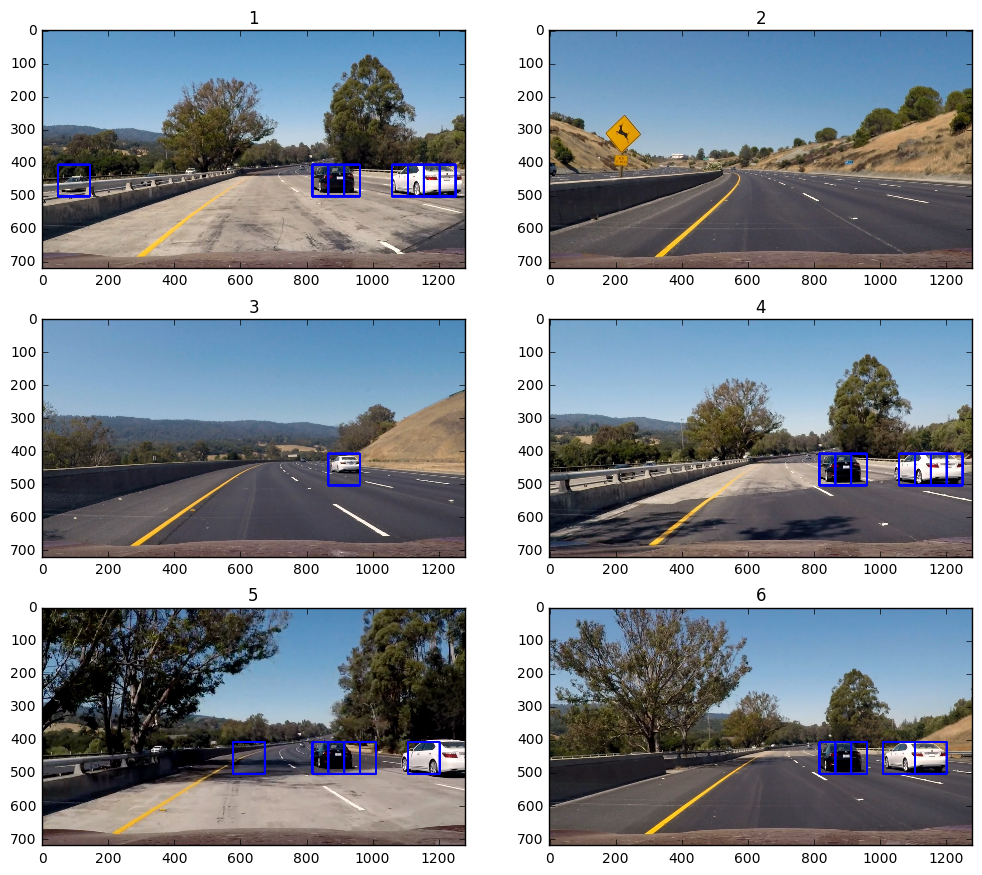

In [9]:
def get_hot_windows(image):
    y_start_stop = [image.shape[0]*.5, image.shape[0]*.9] # Min and max in y to search in slide_window()
    draw_image = np.copy(image)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    y_start_stop = [int(image.shape[0]/2), image.shape[0]]


    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows

test_path = 'test_images/*'
example_images = glob.glob(test_path)
images = []
titles = []

for i in example_images:
    image = mpimg.imread(i)
    hot_windows = get_hot_windows(image)
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)  
    images.append(window_img)
    titles.append('')
    print('Number of windows: %d' % len(hot_windows))
    
fig = plt.figure(figsize = (12,18), dpi = 300)
plot_images(fig,5,2,images,titles)




### Vehicel Tracking with Heap Map
To turn the raw vehicle detections into reliable tracks, I use a heat map.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap. I then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

In order to remove the false positive, I integrate a heatmap over 15 frames of video, , such that areas of multiple detections get "hot", while transient false positives stay "cool". I then simply threshold the integrated heatmap to remove false positives.

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(image, labels):
    '''Draw rectangles around labeled regions'''
    # Iterate through all detected vehicles
   
    for vehicle_id in range(1, labels[1] + 1):
        # Find pixels with each vehicle_id label value
        nonzero = (labels[0] == vehicle_id).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

    # Return the image
    return image



#### Extract HOG featurs just once for the entire region of interest
To speed things up, instead of extract HOG features from each individual windows as I searched across the image, I extract HOG features just once for the entire region of interest (just the lower half of each frame) and subsample that array for each sliding window.
I used the code primarly from the Q/A session of the course.

In [11]:
def find_vehicles(img, scale=1):
    count =0
    img_boxes = []
    draw_img= np.copy(img)
 
    heatmap=np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch=img[ystart:ystop,:,:]
    cimg= cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale!=1:
        imshape = cimg.shape
        cimg = cv2.resize(cimg, (np.int(imshape[1]/scale, np.int(imshape[0]/scale))))
        
    ch1 = cimg[:,:,0]
    ch2 = cimg[:,:,1]
    ch3 = cimg[:,:,2]
    
     
    nxblocks = (ch1.shape[1] // pix_per_cell) -1
    nyblocks = (ch1.shape[0] // pix_per_cell) -1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window= (window // pix_per_cell) -1
    cells_per_step = 2
    nxsteps = (nxblocks-nblocks_per_window) // cells_per_step
    nysteps = (nyblocks-nblocks_per_window) // cells_per_step
    
    #compute invividual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch2,orient,pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range (nxsteps):
        for yb in range (nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features= np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop =  ypos*pix_per_cell
            
            #Extract the image patch
            subimg = cv2.resize(cimg[ytop:ytop+window,xleft:xleft+window],(64,64))
            
            #Get color features
            spatial_features = bin_spatial(subimg, size= spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1,-1))
            test_predictions = svc.predict(test_features)
            
            if test_predictions == 1:
              
                xbox_left= np.int(xleft*scale)
                ytop_draw= np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    
    return draw_img,heatmap, img_boxes
    

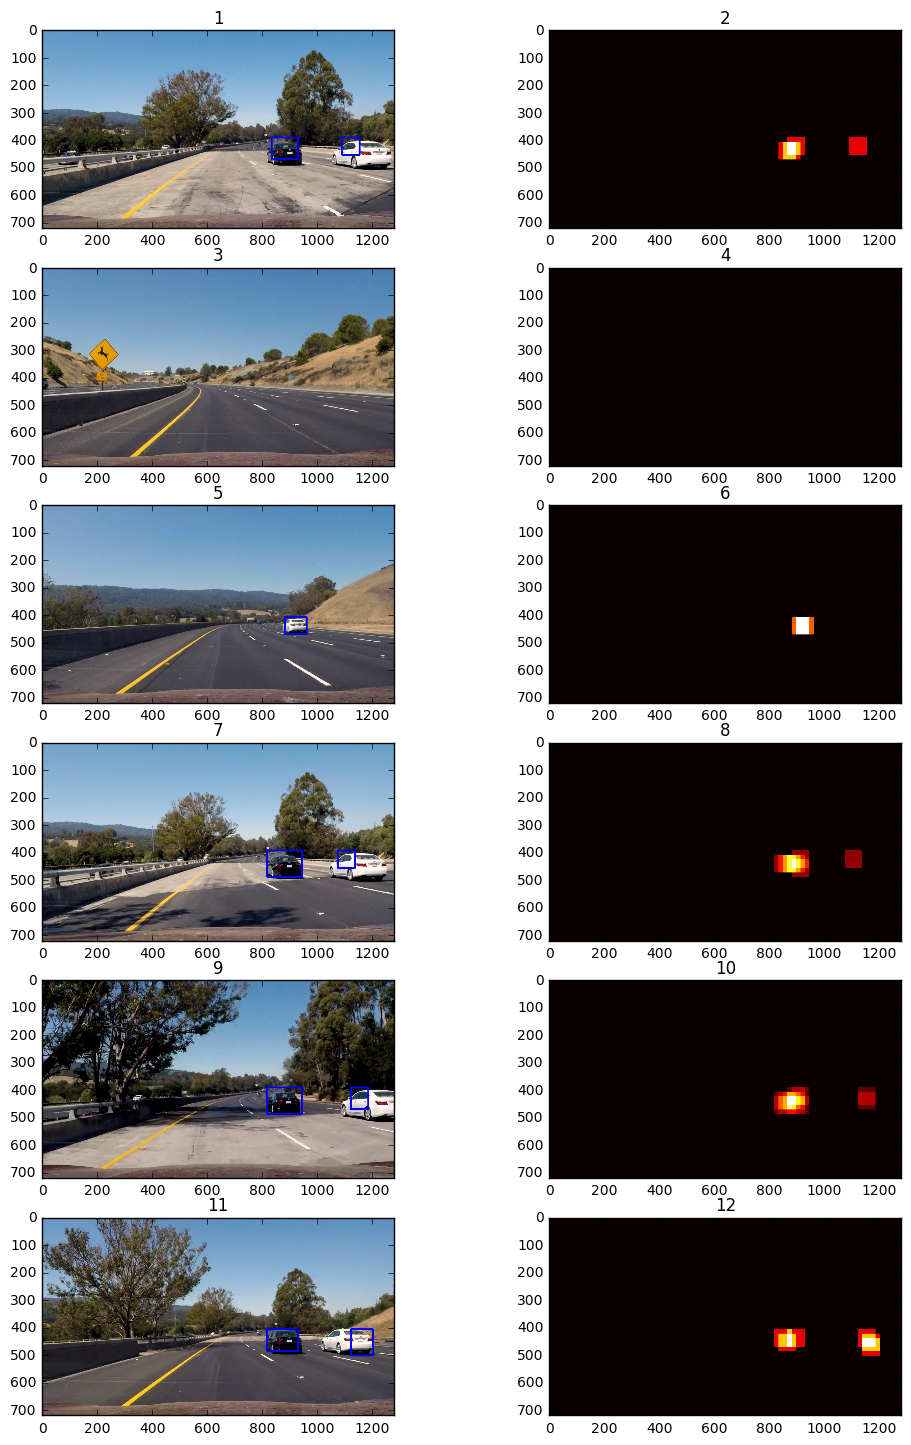

In [12]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

scale = 1
ystart = 360
ystop = 648

#iterate over test images and draw the labeled box and plot the heatmap
for i in example_images:
    img = mpimg.imread(i)
    out_img, heat_map, out_boxes = find_vehicles(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append("")
    
fig= plt.figure(figsize = (12,24))
plot_images(fig, 8,2, out_images,out_titles)
    
    

In [13]:
# Keep a buffer of 15 frames to integrate heatmaps
from collections import deque
class ImageBuffer(deque):
    def __init__(self, size = 15):
            super(ImageBuffer, self).__init__(maxlen = size)
    @property
    def average(self):
        return sum(self)/len(self)


In [14]:
#pipleline to process each frame
def process_img(image, image_buffer, g_heatmap):
    
    out_img,heatmap, out_box = find_vehicles(image, scale)
    image_buffer.append(np.copy(heatmap))
    #integrate heatmap
    for elem in image_buffer:
        g_heatmap = g_heatmap +elem
    average_heat_map = apply_threshold(np.copy(g_heatmap), 2)
    labels = label(average_heat_map)
    g_heatmap = np.zeros_like(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
  

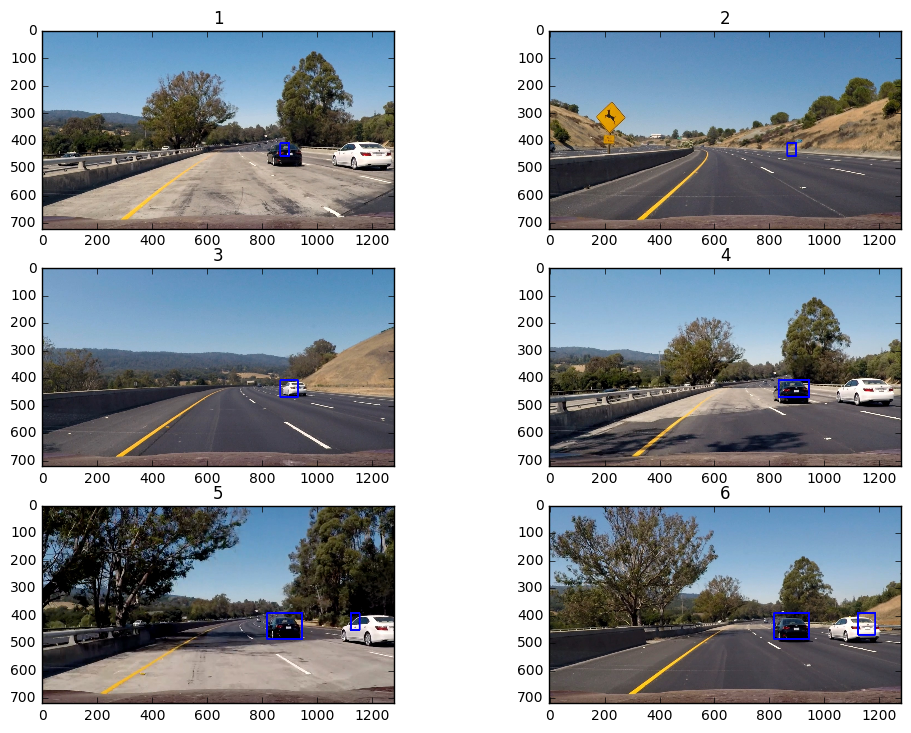

In [15]:
out_images = []
#out_maps = []
#out_titles = []
#out_boxes = []
image = mpimg.imread('test_images/test1.jpg')
heatmap=np.zeros_like(image[:,:,0])

image_buffer = ImageBuffer()
#iterate over test images
for i in example_images:
    img = mpimg.imread(i)
    draw_img=process_img(img, image_buffer,heatmap)
    out_images.append(draw_img)
    #out_images.append(heat_map)
    out_titles.append("")
    
fig= plt.figure(figsize = (12,24))
plot_images(fig, 8,2, out_images,out_titles)
    
    

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

image_buffer = ImageBuffer()

video_frame_example = mpimg.imread('test_images/test1.jpg')
video_heatmap = np.zeros_like(video_frame_example[:,:,0])
process_with_frames = lambda x: process_img(x,image_buffer,video_heatmap)

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_with_frames) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:14<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 15min 51s, sys: 26.4 s, total: 16min 18s
Wall time: 16min 15s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))